In [1]:
from sympy import init_printing
init_printing()

In [2]:
from sympy import Symbol,Matrix,symbols
from sympy import I,conjugate,re,im
from sympy import sin,cos,exp,sqrt,pi
from sympy import pprint
from sympy import simplify
from sympy import KroneckerDelta
from sympy import Function, Derivative
from sympy import solve
from sympy import zeros
from sympy import Integer

from fast.symbolic import define_density_matrix, define_laser_variables, polarization_vector
from fast.symbolic import cartesian_to_helicity, helicity_to_cartesian, helicity_dot_product
from fast.symbolic import define_r_components, define_frequencies
from fast.symbolic import delta_greater, delta_lesser
from fast.symbolic import ket,bra,lindblad_operator,lindblad_terms
from fast.symbolic import define_psi_coefficients
from fast.symbolic import define_rho_vector,calculate_A_b
from fast.symbolic import vector_element

from fast.misc import formatLij
from numpy import array

We define the number of states and of radiation fields.

In [3]:
Ne=3
Nl=2

We define the variables related to the laser field.

In [4]:
E0,omega_laser=define_laser_variables(Nl)
pprint(E0)
pprint(omega_laser)

[E¹₀, E²₀]
[ω¹, ω²]


We define a few important symbols.

In [5]:
t,hbar,e=symbols("t hbar e",positive=True)
pprint([t,hbar,e])

[t, h̅, e]


We write two electric fields propagating trough the $\hat{x}$ direction polarized in the $\hat{z}$ direction. First the wave vectors:

In [6]:
phi=0; theta=pi/2; alpha=pi/2; beta=0

k1=Matrix([cos(phi)*sin(theta),sin(phi)*sin(theta),cos(theta)])
k2=Matrix([cos(phi)*sin(theta),sin(phi)*sin(theta),cos(theta)])

pprint([k1,k2])

⎡⎡1⎤, ⎡1⎤⎤
⎢⎢ ⎥  ⎢ ⎥⎥
⎢⎢0⎥  ⎢0⎥⎥
⎢⎢ ⎥  ⎢ ⎥⎥
⎣⎣0⎦  ⎣0⎦⎦


The polarization vectors.

In [7]:
ep1=polarization_vector(phi,theta,alpha,beta, 1)
ep2=polarization_vector(phi,theta,alpha,beta, 1)

em1=ep1.conjugate()
em2=ep2.conjugate()

ep=[ep1,ep2]
em=[em1,em2]

pprint([ep,em])

⎡⎡⎡0⎤, ⎡0⎤⎤, ⎡⎡0⎤, ⎡0⎤⎤⎤
⎢⎢⎢ ⎥  ⎢ ⎥⎥  ⎢⎢ ⎥  ⎢ ⎥⎥⎥
⎢⎢⎢0⎥  ⎢0⎥⎥  ⎢⎢0⎥  ⎢0⎥⎥⎥
⎢⎢⎢ ⎥  ⎢ ⎥⎥  ⎢⎢ ⎥  ⎢ ⎥⎥⎥
⎣⎣⎣1⎦  ⎣1⎦⎦  ⎣⎣1⎦  ⎣1⎦⎦⎦


The electric field (evaluated in $\vec{R}=0$).

In [8]:
zero_vect=Matrix([0,0,0])
E_cartesian = sum( [E0[l]/2*(ep[l]*exp(-I*omega_laser[l]*t) + em[l]*exp( I*omega_laser[l]*t)) for l in range(Nl)],
                  zero_vect)

pprint(E_cartesian)

⎡                         0                         ⎤
⎢                                                   ⎥
⎢                         0                         ⎥
⎢                                                   ⎥
⎢    ⎛ ⅈ⋅ω¹⋅t    -ⅈ⋅ω¹⋅t⎞       ⎛ ⅈ⋅ω²⋅t    -ⅈ⋅ω²⋅t⎞⎥
⎢E¹₀⋅⎝ℯ       + ℯ       ⎠   E²₀⋅⎝ℯ       + ℯ       ⎠⎥
⎢──────────────────────── + ────────────────────────⎥
⎣           2                          2            ⎦


We write the electric field in the helicity basis.

In [9]:
E=cartesian_to_helicity(E_cartesian)
pprint(E)

⎡                         0                         ⎤
⎢                                                   ⎥
⎢    ⎛ ⅈ⋅ω¹⋅t    -ⅈ⋅ω¹⋅t⎞       ⎛ ⅈ⋅ω²⋅t    -ⅈ⋅ω²⋅t⎞⎥
⎢E¹₀⋅⎝ℯ       + ℯ       ⎠   E²₀⋅⎝ℯ       + ℯ       ⎠⎥
⎢──────────────────────── + ────────────────────────⎥
⎢           2                          2            ⎥
⎢                                                   ⎥
⎣                         0                         ⎦


We define the position operator.

In [10]:
r=define_r_components(Ne,helicity=True,explicitly_hermitian=True)
#Ladder means that r_{p;31}=0
r=[ri.subs({r[0][2,0]:0,r[1][2,0]:0,r[2][2,0]:0}) for ri in r]
pprint(r,num_columns=150)

⎡⎡    0      -r_{+1;21}      0     ⎤, ⎡   0      r_{0;21}     0    ⎤, ⎡    0      -r_{-1;21}      0     ⎤⎤
⎢⎢                                 ⎥  ⎢                            ⎥  ⎢                                 ⎥⎥
⎢⎢r_{-1;21}      0       -r_{+1;32}⎥  ⎢r_{0;21}     0      r_{0;32}⎥  ⎢r_{+1;21}      0       -r_{-1;32}⎥⎥
⎢⎢                                 ⎥  ⎢                            ⎥  ⎢                                 ⎥⎥
⎣⎣    0      r_{-1;32}       0     ⎦  ⎣   0      r_{0;32}     0    ⎦  ⎣    0      r_{+1;32}       0     ⎦⎦


The frequencies of the energy levels, the resonant frequencies, and the decay frequencies.

In [11]:
omega_level,omega,gamma=define_frequencies(Ne,explicitly_antisymmetric=True)
#Ladder means gamma31=0
gamma=gamma.subs({gamma[2,0]:0})

pprint(omega_level)
print
pprint(omega)
print
pprint(gamma)

[ω₁, ω₂, ω₃]

⎡ 0   -ω₂₁  -ω₃₁⎤
⎢               ⎥
⎢ω₂₁   0    -ω₃₂⎥
⎢               ⎥
⎣ω₃₁  ω₃₂    0  ⎦

⎡ 0   -γ₂₁   0  ⎤
⎢               ⎥
⎢γ₂₁   0    -γ₃₂⎥
⎢               ⎥
⎣ 0   γ₃₂    0  ⎦


The atomic hamiltonian is

In [12]:
H0=Matrix([[hbar*omega_level[i]*KroneckerDelta(i,j) for j in range(Ne)] for i in range(Ne)])
pprint(H0)

⎡h̅⋅ω₁    0      0  ⎤
⎢                   ⎥
⎢  0    h̅⋅ω₂    0  ⎥
⎢                   ⎥
⎣  0      0    h̅⋅ω₃⎦


The interaction hamiltonian is

In [13]:
H1=e*helicity_dot_product(E,r)

and the complete hamiltonian is

In [14]:
H=H0+H1

# Rotating wave approximation
Notice that the electric field can be separated by terms with positive and negative frequency:

In [15]:
E_cartesian_p=[E0[l]/2*ep[l]*exp(-I*omega_laser[l]*t) for l in range(Nl)]
E_cartesian_m=[E0[l]/2*em[l]*exp( I*omega_laser[l]*t) for l in range(Nl)]

E_p=[cartesian_to_helicity(E_cartesian_p[l]) for l in range(Nl)]
E_m=[cartesian_to_helicity(E_cartesian_m[l]) for l in range(Nl)]

pprint([E_p,E_m])

⎡⎡⎡     0      ⎤, ⎡     0      ⎤⎤, ⎡⎡     0     ⎤, ⎡     0     ⎤⎤⎤
⎢⎢⎢            ⎥  ⎢            ⎥⎥  ⎢⎢           ⎥  ⎢           ⎥⎥⎥
⎢⎢⎢     -ⅈ⋅ω¹⋅t⎥  ⎢     -ⅈ⋅ω²⋅t⎥⎥  ⎢⎢     ⅈ⋅ω¹⋅t⎥  ⎢     ⅈ⋅ω²⋅t⎥⎥⎥
⎢⎢⎢E¹₀⋅ℯ       ⎥  ⎢E²₀⋅ℯ       ⎥⎥  ⎢⎢E¹₀⋅ℯ      ⎥  ⎢E²₀⋅ℯ      ⎥⎥⎥
⎢⎢⎢────────────⎥  ⎢────────────⎥⎥  ⎢⎢───────────⎥  ⎢───────────⎥⎥⎥
⎢⎢⎢     2      ⎥  ⎢     2      ⎥⎥  ⎢⎢     2     ⎥  ⎢     2     ⎥⎥⎥
⎢⎢⎢            ⎥  ⎢            ⎥⎥  ⎢⎢           ⎥  ⎢           ⎥⎥⎥
⎣⎣⎣     0      ⎦  ⎣     0      ⎦⎦  ⎣⎣     0     ⎦  ⎣     0     ⎦⎦⎦


In [16]:
pprint( simplify(E-(sum([E_p[l]+E_m[l] for l in range(Nl)],zero_vect) )))

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦


The position operator can also be separated in this way. We go to the interaction picture (with $\hat{H}_0$ as the undisturbed hamiltonian)

In [17]:
r_I=[ Matrix([[exp(I*omega[i,j]*t)*r[p][i,j] for j in range(Ne)] for i in range(Ne)]) for p in range(3)]
pprint(r_I[0])
pprint(r_I[1])
pprint(r_I[2])

⎡                                -ⅈ⋅ω₂₁⋅t                      ⎤
⎢        0           -r_{+1;21}⋅ℯ                   0          ⎥
⎢                                                              ⎥
⎢           ⅈ⋅ω₂₁⋅t                                    -ⅈ⋅ω₃₂⋅t⎥
⎢r_{-1;21}⋅ℯ                  0            -r_{+1;32}⋅ℯ        ⎥
⎢                                                              ⎥
⎢                                ⅈ⋅ω₃₂⋅t                       ⎥
⎣        0            r_{-1;32}⋅ℯ                   0          ⎦
⎡                             -ⅈ⋅ω₂₁⋅t                    ⎤
⎢        0          r_{0;21}⋅ℯ                  0         ⎥
⎢                                                         ⎥
⎢          ⅈ⋅ω₂₁⋅t                                -ⅈ⋅ω₃₂⋅t⎥
⎢r_{0;21}⋅ℯ                 0           r_{0;32}⋅ℯ        ⎥
⎢                                                         ⎥
⎢                             ⅈ⋅ω₃₂⋅t                     ⎥
⎣        0          r_{0;32}⋅ℯ                  0         ⎦


Which can be decomposed in positive and negative frequencies as

In [18]:
r_I_p=[ Matrix([[ delta_greater(j,i)*exp(-I*omega[j,i]*t)*r[p][i,j] for j in range(Ne)]for i in range(Ne)]) for p in range(3)]
pprint(r_I_p[0])
pprint(r_I_p[1])
pprint(r_I_p[2])

⎡               -ⅈ⋅ω₂₁⋅t                      ⎤
⎢0  -r_{+1;21}⋅ℯ                   0          ⎥
⎢                                             ⎥
⎢                                     -ⅈ⋅ω₃₂⋅t⎥
⎢0           0            -r_{+1;32}⋅ℯ        ⎥
⎢                                             ⎥
⎣0           0                     0          ⎦
⎡             -ⅈ⋅ω₂₁⋅t                    ⎤
⎢0  r_{0;21}⋅ℯ                  0         ⎥
⎢                                         ⎥
⎢                                 -ⅈ⋅ω₃₂⋅t⎥
⎢0          0           r_{0;32}⋅ℯ        ⎥
⎢                                         ⎥
⎣0          0                   0         ⎦
⎡               -ⅈ⋅ω₂₁⋅t                      ⎤
⎢0  -r_{-1;21}⋅ℯ                   0          ⎥
⎢                                             ⎥
⎢                                     -ⅈ⋅ω₃₂⋅t⎥
⎢0           0            -r_{-1;32}⋅ℯ        ⎥
⎢                                             ⎥
⎣0           0                     0          ⎦


In [19]:
r_I_m=[ Matrix([[ delta_lesser( j,i)*exp( I*omega[i,j]*t)*r[p][i,j] for j in range(Ne)]for i in range(Ne)]) for p in range(3)]
pprint(r_I_m[0])
pprint(r_I_m[1])
pprint(r_I_m[2])

⎡        0                   0           0⎤
⎢                                         ⎥
⎢           ⅈ⋅ω₂₁⋅t                       ⎥
⎢r_{-1;21}⋅ℯ                 0           0⎥
⎢                                         ⎥
⎢                               ⅈ⋅ω₃₂⋅t   ⎥
⎣        0           r_{-1;32}⋅ℯ         0⎦
⎡        0                  0          0⎤
⎢                                       ⎥
⎢          ⅈ⋅ω₂₁⋅t                      ⎥
⎢r_{0;21}⋅ℯ                 0          0⎥
⎢                                       ⎥
⎢                             ⅈ⋅ω₃₂⋅t   ⎥
⎣        0          r_{0;32}⋅ℯ         0⎦
⎡        0                   0           0⎤
⎢                                         ⎥
⎢           ⅈ⋅ω₂₁⋅t                       ⎥
⎢r_{+1;21}⋅ℯ                 0           0⎥
⎢                                         ⎥
⎢                               ⅈ⋅ω₃₂⋅t   ⎥
⎣        0           r_{+1;32}⋅ℯ         0⎦


that summed equal $\vec{\hat{r}}_I$

In [20]:
pprint( [r_I[p]-(r_I_p[p]+r_I_m[p]) for p in range(3)] )

⎡⎡0  0  0⎤, ⎡0  0  0⎤, ⎡0  0  0⎤⎤
⎢⎢       ⎥  ⎢       ⎥  ⎢       ⎥⎥
⎢⎢0  0  0⎥  ⎢0  0  0⎥  ⎢0  0  0⎥⎥
⎢⎢       ⎥  ⎢       ⎥  ⎢       ⎥⎥
⎣⎣0  0  0⎦  ⎣0  0  0⎦  ⎣0  0  0⎦⎦


Thus the interaction hamiltonian in the interaciton picture is
\begin{equation}
    \hat{H}_{1I}=e\vec{E}\cdot \vec{\hat{r}}_I= e(\vec{E}^{(+)}\cdot \vec{\hat{r}}^{(+)}_I + \vec{E}^{(+)}\cdot \vec{\hat{r}}^{(-)}_I + \vec{E}^{(-)}\cdot \vec{\hat{r}}^{(+)}_I + \vec{E}^{(-)}\cdot \vec{\hat{r}}^{(-)}_I)
\end{equation}

In [22]:
H1I=e*helicity_dot_product(E,r_I)

Since both $\omega^l$ and $\omega_{ij}$ are in the order of THz, the terms that have frequencies with the same sign are summed, and thus also of the order of THz. The frequencies in the terms with oposite signs however, are detunings of the order of MHz. Since we are only interested in the coarse-grained evolution of the density matrix, we may omit the fast terms and approximate

\begin{equation}
    \hat{H}_{1I} \simeq \hat{H}_{1I,RWA}= e( \vec{E}^{(+)}\cdot \vec{\hat{r}}^{(-)}_I + \vec{E}^{(-)}\cdot \vec{\hat{r}}^{(+)}_I )
\end{equation}

That is known as the rotating wave approximation (RWA).

In [24]:
zero_matrix=zeros(Ne,Ne)
H1IRWA=sum( [ (e*(helicity_dot_product(E_p[l],r_I_m)+helicity_dot_product(E_m[l],r_I_p))) for l in range(Nl)],zero_matrix)

For instance, the $(\hat{H}_{1I,RWA})_{21}$ element is

In [26]:
pprint(H1IRWA[1,0].expand())

                -ⅈ⋅ω¹⋅t  ⅈ⋅ω₂₁⋅t                   -ⅈ⋅ω²⋅t  ⅈ⋅ω₂₁⋅t
E¹₀⋅e⋅r_{0;21}⋅ℯ       ⋅ℯ          E²₀⋅e⋅r_{0;21}⋅ℯ       ⋅ℯ       
──────────────────────────────── + ────────────────────────────────
               2                                  2                


But if the detuning $\omega_{21}-\omega^1 \ll \omega_{21}-\omega^2$ (the second field is far detuned from the $1 \rightarrow 2$ transition), then $\omega_{21}-\omega^2$ may be also considered too high a frequency to be relevant to coarse-grained evolution. So we might neclect that term in $(\hat{H}_{1I,RWA})_{21}$ and similarly neglect the $\omega_{32}-\omega^1$ for term in $(\hat{H}_{1I,RWA})_{32}$:

In [27]:
pprint(H1IRWA[2,1].expand())

                -ⅈ⋅ω¹⋅t  ⅈ⋅ω₃₂⋅t                   -ⅈ⋅ω²⋅t  ⅈ⋅ω₃₂⋅t
E¹₀⋅e⋅r_{0;32}⋅ℯ       ⋅ℯ          E²₀⋅e⋅r_{0;32}⋅ℯ       ⋅ℯ       
──────────────────────────────── + ────────────────────────────────
               2                                  2                


In other words, if the detunings in our experiments allow the approximmation, we might choose which frequency components $\omega^l$ excite which transitions. Let us say that $L_{ij}$ is the set of $l$ such that $\omega^l$ excites the transition $i\rightarrow j$

In [29]:
Lij=[[1,2,[1]],[2,3,[2]]]
Lij=formatLij(Lij,Ne)
print array(Lij)

[[[] [1] []]
 [[1] [] [2]]
 [[] [2] []]]


Thus the interacion hamiltonian in the interaction picture can be approximated as

In [31]:
H1IRWA =sum([ e*( helicity_dot_product( E_p[l],vector_element(r_I_m,i,j)) ) * ket(i+1,Ne)*bra(j+1,Ne) 
            for l in range(Nl) for j in range(Ne) for i in range(Ne) if l+1 in Lij[i][j] ],zero_matrix)
H1IRWA+=sum([ e*( helicity_dot_product( E_m[l],vector_element(r_I_p,i,j)) ) * ket(i+1,Ne)*bra(j+1,Ne) 
            for l in range(Nl) for j in range(Ne) for i in range(Ne) if l+1 in Lij[i][j] ],zero_matrix)

pprint(H1IRWA,num_columns=150)

⎡                                                  ⅈ⋅ω¹⋅t  -ⅈ⋅ω₂₁⋅t                                  ⎤
⎢                                  E¹₀⋅e⋅r_{0;21}⋅ℯ      ⋅ℯ                                          ⎥
⎢               0                  ────────────────────────────────                 0                ⎥
⎢                                                 2                                                  ⎥
⎢                                                                                                    ⎥
⎢                -ⅈ⋅ω¹⋅t  ⅈ⋅ω₂₁⋅t                                                    ⅈ⋅ω²⋅t  -ⅈ⋅ω₃₂⋅t⎥
⎢E¹₀⋅e⋅r_{0;21}⋅ℯ       ⋅ℯ                                           E²₀⋅e⋅r_{0;32}⋅ℯ      ⋅ℯ        ⎥
⎢────────────────────────────────                 0                  ────────────────────────────────⎥
⎢               2                                                                   2                ⎥
⎢                                                                        

 Returning to the Schrödinger picture we have.

In [32]:
r_p=[ Matrix([[ delta_greater(j,i)*r[p][i,j] for j in range(Ne)]for i in range(Ne)]) for p in range(3)]
pprint(r_p,num_columns=150)

⎡⎡0  -r_{+1;21}      0     ⎤, ⎡0  r_{0;21}     0    ⎤, ⎡0  -r_{-1;21}      0     ⎤⎤
⎢⎢                         ⎥  ⎢                     ⎥  ⎢                         ⎥⎥
⎢⎢0      0       -r_{+1;32}⎥  ⎢0     0      r_{0;32}⎥  ⎢0      0       -r_{-1;32}⎥⎥
⎢⎢                         ⎥  ⎢                     ⎥  ⎢                         ⎥⎥
⎣⎣0      0           0     ⎦  ⎣0     0         0    ⎦  ⎣0      0           0     ⎦⎦


In [33]:
r_m=[ Matrix([[ delta_lesser( j,i)*r[p][i,j] for j in range(Ne)]for i in range(Ne)]) for p in range(3)]
pprint(r_m,num_columns=150)

⎡⎡    0          0      0⎤, ⎡   0         0      0⎤, ⎡    0          0      0⎤⎤
⎢⎢                       ⎥  ⎢                     ⎥  ⎢                       ⎥⎥
⎢⎢r_{-1;21}      0      0⎥  ⎢r_{0;21}     0      0⎥  ⎢r_{+1;21}      0      0⎥⎥
⎢⎢                       ⎥  ⎢                     ⎥  ⎢                       ⎥⎥
⎣⎣    0      r_{-1;32}  0⎦  ⎣   0      r_{0;32}  0⎦  ⎣    0      r_{+1;32}  0⎦⎦


In [34]:
pprint( [r[p]-(r_p[p]+r_m[p]) for p in range(3)] )

⎡⎡0  0  0⎤, ⎡0  0  0⎤, ⎡0  0  0⎤⎤
⎢⎢       ⎥  ⎢       ⎥  ⎢       ⎥⎥
⎢⎢0  0  0⎥  ⎢0  0  0⎥  ⎢0  0  0⎥⎥
⎢⎢       ⎥  ⎢       ⎥  ⎢       ⎥⎥
⎣⎣0  0  0⎦  ⎣0  0  0⎦  ⎣0  0  0⎦⎦


Thus the interaction hamiltonian in the Schrödinger picture in the rotating wave approximation is

In [36]:
H1RWA =sum([ e*( helicity_dot_product( E_p[l],vector_element(r_m,i,j)) ) * ket(i+1,Ne)*bra(j+1,Ne) 
            for l in range(Nl) for j in range(Ne) for i in range(Ne) if l+1 in Lij[i][j] ],zero_matrix)
H1RWA+=sum([ e*( helicity_dot_product( E_m[l],vector_element(r_p,i,j)) ) * ket(i+1,Ne)*bra(j+1,Ne) 
            for l in range(Nl) for j in range(Ne) for i in range(Ne) if l+1 in Lij[i][j] ],zero_matrix)

pprint(H1RWA,num_columns=150)

⎡                                         ⅈ⋅ω¹⋅t                         ⎤
⎢                         E¹₀⋅e⋅r_{0;21}⋅ℯ                               ⎥
⎢           0             ──────────────────────             0           ⎥
⎢                                   2                                    ⎥
⎢                                                                        ⎥
⎢                -ⅈ⋅ω¹⋅t                                           ⅈ⋅ω²⋅t⎥
⎢E¹₀⋅e⋅r_{0;21}⋅ℯ                                  E²₀⋅e⋅r_{0;32}⋅ℯ      ⎥
⎢───────────────────────             0             ──────────────────────⎥
⎢           2                                                2           ⎥
⎢                                                                        ⎥
⎢                                         -ⅈ⋅ω²⋅t                        ⎥
⎢                         E²₀⋅e⋅r_{0;32}⋅ℯ                               ⎥
⎢           0             ───────────────────────            0           ⎥
⎣                        

And the complete hamiltonian in the Schrödinger picture in the rotating wave approximation is

In [37]:
HRWA=H0+H1RWA
pprint(HRWA)

⎡                                         ⅈ⋅ω¹⋅t                         ⎤
⎢                         E¹₀⋅e⋅r_{0;21}⋅ℯ                               ⎥
⎢         h̅⋅ω₁           ──────────────────────             0           ⎥
⎢                                   2                                    ⎥
⎢                                                                        ⎥
⎢                -ⅈ⋅ω¹⋅t                                           ⅈ⋅ω²⋅t⎥
⎢E¹₀⋅e⋅r_{0;21}⋅ℯ                                  E²₀⋅e⋅r_{0;32}⋅ℯ      ⎥
⎢───────────────────────           h̅⋅ω₂           ──────────────────────⎥
⎢           2                                                2           ⎥
⎢                                                                        ⎥
⎢                                         -ⅈ⋅ω²⋅t                        ⎥
⎢                         E²₀⋅e⋅r_{0;32}⋅ℯ                               ⎥
⎢           0             ───────────────────────          h̅⋅ω₃         ⎥
⎣                        

# Rotating Frame
Next we will make a phase transformation in order to eliminate the explicit time dependance of the equations.

In [38]:
c,ctilde,phase=define_psi_coefficients(Ne)
pprint([c,ctilde,phase])

⎡⎡c₁(t)⎤, ⎡\tilde{c}_{1}(t)⎤, ⎡θ₁⎤⎤
⎢⎢     ⎥  ⎢                ⎥  ⎢  ⎥⎥
⎢⎢c₂(t)⎥  ⎢\tilde{c}_{2}(t)⎥  ⎢θ₂⎥⎥
⎢⎢     ⎥  ⎢                ⎥  ⎢  ⎥⎥
⎣⎣c₃(t)⎦  ⎣\tilde{c}_{3}(t)⎦  ⎣θ₃⎦⎦


In [39]:
psi=Matrix([ exp(I*phase[i]*t)*ctilde[i] for i in range(Ne)])
pprint(psi)

⎡                  ⅈ⋅t⋅θ₁⎤
⎢\tilde{c}_{1}(t)⋅ℯ      ⎥
⎢                        ⎥
⎢                  ⅈ⋅t⋅θ₂⎥
⎢\tilde{c}_{2}(t)⋅ℯ      ⎥
⎢                        ⎥
⎢                  ⅈ⋅t⋅θ₃⎥
⎣\tilde{c}_{3}(t)⋅ℯ      ⎦


The Schrödinger equation $i\hbar \partial_t |\psi\rangle=\hat{H}_{RWA}$ is

In [40]:
lhs=Matrix([(I*hbar*Derivative(psi[i],t).doit()).expand() for i in range(Ne)])
pprint(lhs)

⎡                         ⅈ⋅t⋅θ₁⎤
⎢-h̅⋅θ₁⋅\tilde{c}_{1}(t)⋅ℯ      ⎥
⎢                               ⎥
⎢                         ⅈ⋅t⋅θ₂⎥
⎢-h̅⋅θ₂⋅\tilde{c}_{2}(t)⋅ℯ      ⎥
⎢                               ⎥
⎢                         ⅈ⋅t⋅θ₃⎥
⎣-h̅⋅θ₃⋅\tilde{c}_{3}(t)⋅ℯ      ⎦


In [41]:
rhs=HRWA*psi
pprint(rhs,num_columns=120)

⎡                                                          ⅈ⋅ω¹⋅t  ⅈ⋅t⋅θ₂                                             
⎢                         E¹₀⋅e⋅r_{0;21}⋅\tilde{c}_{2}(t)⋅ℯ      ⋅ℯ                                 ⅈ⋅t⋅θ₁            
⎢                         ─────────────────────────────────────────────── + h̅⋅ω₁⋅\tilde{c}_{1}(t)⋅ℯ                  
⎢                                                2                                                                    
⎢                                                                                                                     
⎢                                 -ⅈ⋅ω¹⋅t  ⅈ⋅t⋅θ₁                                    ⅈ⋅ω²⋅t  ⅈ⋅t⋅θ₃                   
⎢E¹₀⋅e⋅r_{0;21}⋅\tilde{c}_{1}(t)⋅ℯ       ⋅ℯ         E²₀⋅e⋅r_{0;32}⋅\tilde{c}_{3}(t)⋅ℯ      ⋅ℯ                         
⎢──────────────────────────────────────────────── + ─────────────────────────────────────────────── + h̅⋅ω₂⋅\tilde{c}_
⎢                       2                       

We multiply each of these equations by $e^{-i \theta_i t}$ and substracting $i \theta_i \tilde{c}_i$

In [42]:
lhs_new=Matrix([simplify(  lhs[i]*exp(-I*phase[i]*t) +hbar*phase[i]*ctilde[i] ) for i in range(Ne)])
pprint(lhs_new)

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦


In [57]:
rhs_new=Matrix([simplify(  rhs[i]*exp(-I*phase[i]*t) +hbar*phase[i]*ctilde[i] ) for i in range(Ne)])
pprint(rhs_new,num_columns=120)

⎡                                                               ⅈ⋅ω¹⋅t  -ⅈ⋅t⋅θ₁  ⅈ⋅t⋅θ₂                               
⎢                              E¹₀⋅e⋅r_{0;21}⋅\tilde{c}_{2}(t)⋅ℯ      ⋅ℯ       ⋅ℯ                                     
⎢                              ──────────────────────────────────────────────────────── + h̅⋅ω₁⋅\tilde{c}_{1}(t) + h̅⋅
⎢                                                         2                                                           
⎢                                                                                                                     
⎢                                 -ⅈ⋅ω¹⋅t  ⅈ⋅t⋅θ₁  -ⅈ⋅t⋅θ₂                                    ⅈ⋅ω²⋅t  -ⅈ⋅t⋅θ₂  ⅈ⋅t⋅θ₃ 
⎢E¹₀⋅e⋅r_{0;21}⋅\tilde{c}_{1}(t)⋅ℯ       ⋅ℯ      ⋅ℯ          E²₀⋅e⋅r_{0;32}⋅\tilde{c}_{3}(t)⋅ℯ      ⋅ℯ       ⋅ℯ       
⎢───────────────────────────────────────────────────────── + ──────────────────────────────────────────────────────── 
⎢                            2                  

It can be seen that the equations loose their explicit time dependance only if $\omega^{1} - \theta_{1} + \theta_{2}=0$ and $\omega^{2} - \theta_{2} + \theta_{3}=0$. Which is satisfied if

In [59]:
phase_transformation=solve([omega_laser[0]-phase[0]+phase[1],omega_laser[1]-phase[1]+phase[2]],[phase[1],phase[2]],
                           dict=True)[0]
pprint(phase_transformation)

{θ₂: -ω¹ + θ₁, θ₃: -ω¹ - ω² + θ₁}


There is a free parameter $\theta_1$, which is to be expected, since state vetors $|\psi\rangle$ always have a global phase invariance

In [60]:
pprint(psi.subs(phase_transformation))

⎡                        ⅈ⋅t⋅θ₁       ⎤
⎢      \tilde{c}_{1}(t)⋅ℯ             ⎥
⎢                                     ⎥
⎢                    ⅈ⋅t⋅(-ω¹ + θ₁)   ⎥
⎢  \tilde{c}_{2}(t)⋅ℯ                 ⎥
⎢                                     ⎥
⎢                  ⅈ⋅t⋅(-ω¹ - ω² + θ₁)⎥
⎣\tilde{c}_{3}(t)⋅ℯ                   ⎦


Thus the equations become

In [61]:
pprint(lhs_new)

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦


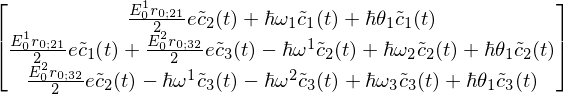

In [62]:
rhs_new=simplify(rhs_new.subs(phase_transformation)).expand()
rhs_new

It can be seen that this is the Schrödinger equation derived from an effective hamiltonian $\tilde{H}$

In [70]:
Htilde=Matrix([ [Derivative(rhs_new[i],ctilde[j]).doit() for j in range(Ne)] for i in range(Ne)])
pprint(Htilde)

⎡                    E¹₀⋅e⋅r_{0;21}                                    ⎤
⎢h̅⋅ω₁ + h̅⋅θ₁       ──────────────                    0               ⎥
⎢                          2                                           ⎥
⎢                                                                      ⎥
⎢E¹₀⋅e⋅r_{0;21}                                  E²₀⋅e⋅r_{0;32}        ⎥
⎢──────────────  -h̅⋅ω¹ + h̅⋅ω₂ + h̅⋅θ₁          ──────────────        ⎥
⎢      2                                               2               ⎥
⎢                                                                      ⎥
⎢                    E²₀⋅e⋅r_{0;32}                                    ⎥
⎢      0             ──────────────      -h̅⋅ω¹ - h̅⋅ω² + h̅⋅ω₃ + h̅⋅θ₁⎥
⎣                          2                                           ⎦


We can see that it is convenient to choose $\theta_1=-\omega_1$ to simplify the hamiltonian. Also, we can recognize $\omega^1-\omega_2+\omega_1=\delta^1$ as the detuning of the first field relative to the atomic transition $\omega_{21}=\omega_2-\omega_1$, and the same for $\omega^2-\omega_3+\omega_2=\delta^2$.

In [71]:
delta1,delta2=symbols("delta1 delta2",real=True)
Htilde=Htilde.subs({phase[0]:-omega_level[0]})
Htilde=Htilde.subs({omega_laser[0]:delta1+omega_level[1]-omega_level[0]})
Htilde=Htilde.subs({omega_laser[1]:delta2+omega_level[2]-omega_level[1]})

Htilde=Htilde.expand()

pprint(Htilde)

⎡                E¹₀⋅e⋅r_{0;21}                ⎤
⎢      0         ──────────────        0       ⎥
⎢                      2                       ⎥
⎢                                              ⎥
⎢E¹₀⋅e⋅r_{0;21}                  E²₀⋅e⋅r_{0;32}⎥
⎢──────────────      -δ₁⋅h̅      ──────────────⎥
⎢      2                               2       ⎥
⎢                                              ⎥
⎢                E²₀⋅e⋅r_{0;32}                ⎥
⎢      0         ──────────────  -δ₁⋅h̅ - δ₂⋅h̅⎥
⎣                      2                       ⎦


If we define the Rabi frequencies $\Omega_1 =e E_0^1 r_{0;21}/\hbar$ and $\Omega_2 =e E_0^2 r_{0;32}/\hbar$

In [72]:
Omega1,Omega2=symbols("Omega1 Omega2",real=True)
Htilde=Htilde.subs({r[1][1,0]:Omega1*hbar/E0[0]/e})
Htilde=Htilde.subs({r[1][2,1]:Omega2*hbar/E0[1]/e})

pprint(Htilde)

⎡       Ω₁⋅h̅                 ⎤
⎢  0    ─────         0       ⎥
⎢         2                   ⎥
⎢                             ⎥
⎢Ω₁⋅h̅              Ω₂⋅h̅     ⎥
⎢─────  -δ₁⋅h̅      ─────     ⎥
⎢  2                  2       ⎥
⎢                             ⎥
⎢       Ω₂⋅h̅                 ⎥
⎢  0    ─────   -δ₁⋅h̅ - δ₂⋅h̅⎥
⎣         2                   ⎦


We define the density matrix.

In [73]:
rho=define_density_matrix(Ne)
pprint( rho )

⎡ρ₁₁  ρ₁₂  ρ₁₃⎤
⎢             ⎥
⎢ρ₂₁  ρ₂₂  ρ₂₃⎥
⎢             ⎥
⎣ρ₃₁  ρ₃₂  ρ₃₃⎦


The hamiltonian part of the equations is
\begin{equation}
    \dot{\hat{\rho}}=\frac{i}{\hbar}[\hat{\rho}, \hat{\tilde{H}}]
\end{equation}

In [75]:
hamiltonian_terms=(I/hbar*(rho*Htilde-Htilde*rho)).expand()

There is only one Lindblad operator, since there is only one spontaneous decay channel.

In [76]:
lindblad_terms =gamma[1,0]*lindblad_operator(ket(1,Ne)*bra(2,Ne),rho)
lindblad_terms+=gamma[2,1]*lindblad_operator(ket(2,Ne)*bra(3,Ne),rho)

pprint(lindblad_terms, num_columns=120)

⎡                -γ₂₁⋅ρ₁₂             -γ₃₂⋅ρ₁₃      ⎤
⎢ γ₂₁⋅ρ₂₂        ─────────            ─────────     ⎥
⎢                    2                    2         ⎥
⎢                                                   ⎥
⎢-γ₂₁⋅ρ₂₁                          γ₂₁⋅ρ₂₃   γ₃₂⋅ρ₂₃⎥
⎢─────────  -γ₂₁⋅ρ₂₂ + γ₃₂⋅ρ₃₃   - ─────── - ───────⎥
⎢    2                                2         2   ⎥
⎢                                                   ⎥
⎢-γ₃₂⋅ρ₃₁     γ₂₁⋅ρ₃₂   γ₃₂⋅ρ₃₂                     ⎥
⎢─────────  - ─────── - ───────       -γ₃₂⋅ρ₃₃      ⎥
⎣    2           2         2                        ⎦


# Optical Bloch Equations
The Optical Bloch equations are thus.

In [77]:
eqs=hamiltonian_terms + lindblad_terms
pprint(eqs,num_columns=120)

⎡            ⅈ⋅Ω₁⋅ρ₁₂   ⅈ⋅Ω₁⋅ρ₂₁                              ⅈ⋅Ω₁⋅ρ₁₁   ⅈ⋅Ω₁⋅ρ₂₂   ⅈ⋅Ω₂⋅ρ₁₃              γ₂₁⋅ρ₁₂     
⎢            ──────── - ──────── + γ₂₁⋅ρ₂₂                    ──────── - ──────── + ──────── - ⅈ⋅δ₁⋅ρ₁₂ - ───────     
⎢               2          2                                     2          2          2                     2        
⎢                                                                                                                     
⎢  ⅈ⋅Ω₁⋅ρ₁₁   ⅈ⋅Ω₁⋅ρ₂₂   ⅈ⋅Ω₂⋅ρ₃₁              γ₂₁⋅ρ₂₁    ⅈ⋅Ω₁⋅ρ₁₂   ⅈ⋅Ω₁⋅ρ₂₁   ⅈ⋅Ω₂⋅ρ₂₃   ⅈ⋅Ω₂⋅ρ₃₂                   
⎢- ──────── + ──────── - ──────── + ⅈ⋅δ₁⋅ρ₂₁ - ───────  - ──────── + ──────── + ──────── - ──────── - γ₂₁⋅ρ₂₂ + γ₃₂⋅ρ₃
⎢     2          2          2                     2          2          2          2          2                       
⎢                                                                                                                     
⎢ ⅈ⋅Ω₁⋅ρ₃₂   ⅈ⋅Ω₂⋅ρ₂₁                         γ₃

which is how most literature will show the equations. However, a more convenient way to express this equations is to explicitly asume a normalized and hermitian density matrix

In [78]:
rho=define_density_matrix(Ne,explicitly_hermitian=True,normalized=True)
pprint( rho )

⎡                ___  ___⎤
⎢-ρ₂₂ - ρ₃₃ + 1  ρ₂₁  ρ₃₁⎥
⎢                        ⎥
⎢                     ___⎥
⎢     ρ₂₁        ρ₂₂  ρ₃₂⎥
⎢                        ⎥
⎣     ρ₃₁        ρ₃₂  ρ₃₃⎦


In [79]:
hamiltonian_terms = (I/hbar*(rho*Htilde-Htilde*rho)).expand()
lindblad_terms    =gamma[1,0]*lindblad_operator(ket(1,Ne)*bra(2,Ne),rho)
eqs=hamiltonian_terms + lindblad_terms
pprint(eqs,num_columns=120)

⎡                               ___                                                             ___                  _
⎢               ⅈ⋅Ω₁⋅ρ₂₁   ⅈ⋅Ω₁⋅ρ₂₁                                      ⅈ⋅Ω₁⋅ρ₃₃   ⅈ⋅Ω₁   ⅈ⋅Ω₂⋅ρ₃₁        ___   γ₂₁⋅ρ
⎢             - ──────── + ──────── + γ₂₁⋅ρ₂₂                -ⅈ⋅Ω₁⋅ρ₂₂ - ──────── + ──── + ──────── - ⅈ⋅δ₁⋅ρ₂₁ - ─────
⎢                  2          2                                             2        2        2                     2 
⎢                                                                                                                     
⎢                                                                                ___                   ___            
⎢           ⅈ⋅Ω₁⋅ρ₃₃   ⅈ⋅Ω₁   ⅈ⋅Ω₂⋅ρ₃₁              γ₂₁⋅ρ₂₁      ⅈ⋅Ω₁⋅ρ₂₁   ⅈ⋅Ω₁⋅ρ₂₁   ⅈ⋅Ω₂⋅ρ₃₂   ⅈ⋅Ω₂⋅ρ₃₂            
⎢ⅈ⋅Ω₁⋅ρ₂₂ + ──────── - ──── - ──────── + ⅈ⋅δ₁⋅ρ₂₁ - ───────      ──────── - ──────── - ──────── + ──────── - γ₂₁⋅ρ₂₂  
⎢              2        2        2              

and only consider the equations for the populations $\rho_{ii}$ for $i>1$ and the real and imaginary parts of the coherences below the diagonal.

In [80]:
pprint( re(eqs[1,1]) )

-Ω₁⋅im(ρ₂₁) + Ω₂⋅im(ρ₃₂) - γ₂₁⋅ρ₂₂


In [81]:
pprint( re(eqs[1,0]) )

Ω₂⋅im(ρ₃₁)                γ₂₁⋅re(ρ₂₁)
────────── - δ₁⋅im(ρ₂₁) - ───────────
    2                          2     


In [82]:
pprint( im(eqs[1,0]) )

         Ω₁⋅ρ₃₃   Ω₁   Ω₂⋅re(ρ₃₁)                γ₂₁⋅im(ρ₂₁)
Ω₁⋅ρ₂₂ + ────── - ── - ────────── + δ₁⋅re(ρ₂₁) - ───────────
           2      2        2                          2     


If the density matrix is represented as a vector whose components are the these independent components of the density matrix

In [83]:
rho_vect=define_rho_vector(rho,Ne)
pprint(rho_vect)

⎡  ρ₂₂  ⎤
⎢       ⎥
⎢  ρ₃₃  ⎥
⎢       ⎥
⎢re(ρ₂₁)⎥
⎢       ⎥
⎢re(ρ₃₁)⎥
⎢       ⎥
⎢re(ρ₃₂)⎥
⎢       ⎥
⎢im(ρ₂₁)⎥
⎢       ⎥
⎢im(ρ₃₁)⎥
⎢       ⎥
⎣im(ρ₃₂)⎦


Then the equations can be re-written as linear combinations of these components plus an independent term.
\begin{equation}
    \dot{\vec{\rho}} = \hat{A} \vec{\rho} + \vec{b}
\end{equation}
with $\hat{A}$ a linear operator acting in this vector space and $\vec{b}$ the vector of independent terms.

In [84]:
A,b=calculate_A_b(eqs,rho,Ne)
pprint([A,b])

⎡⎡-γ₂₁  0     0       0       0     -Ω₁      0       Ω₂  ⎤, ⎡0 ⎤⎤
⎢⎢                                                       ⎥  ⎢  ⎥⎥
⎢⎢ 0    0     0       0       0      0       0       -Ω₂ ⎥  ⎢0 ⎥⎥
⎢⎢                                                       ⎥  ⎢  ⎥⎥
⎢⎢          -γ₂₁                             Ω₂          ⎥  ⎢0 ⎥⎥
⎢⎢ 0    0   ─────     0       0     -δ₁      ──       0  ⎥  ⎢  ⎥⎥
⎢⎢            2                              2           ⎥  ⎢0 ⎥⎥
⎢⎢                                                       ⎥  ⎢  ⎥⎥
⎢⎢                                  Ω₂              -Ω₁  ⎥  ⎢0 ⎥⎥
⎢⎢ 0    0     0       0       0     ──    -δ₁ - δ₂  ──── ⎥  ⎢  ⎥⎥
⎢⎢                                  2                2   ⎥  ⎢Ω₁⎥⎥
⎢⎢                                                       ⎥  ⎢──⎥⎥
⎢⎢                          -γ₂₁            -Ω₁          ⎥  ⎢2 ⎥⎥
⎢⎢ 0    0     0       0     ─────    0      ────     -δ₂ ⎥  ⎢  ⎥⎥
⎢⎢                            2              2           ⎥  ⎢0 ⎥⎥
⎢⎢        

Explicitly, this is

In [53]:
eqs_new=A*rho_vect - b
pprint(eqs_new)

⎡       -Ω⋅im(ρ₂₁) - γ₂₁⋅ρ₂₂        ⎤
⎢                                   ⎥
⎢                  γ₂₁⋅re(ρ₂₁)      ⎥
⎢     -δ⋅im(ρ₂₁) - ───────────      ⎥
⎢                       2           ⎥
⎢                                   ⎥
⎢        Ω               γ₂₁⋅im(ρ₂₁)⎥
⎢Ω⋅ρ₂₂ - ─ + δ⋅re(ρ₂₁) - ───────────⎥
⎣        2                    2     ⎦


Which is the same as the equations in the previous form.

In [54]:
pprint( eqs_new - Matrix([re(eqs[1,1]),re(eqs[1,0]),im(eqs[1,0])]) )

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦


The steady state solution of this equations is

In [55]:
sol=solve(list(eqs_new),list(rho_vect))
pprint( sol ,num_columns=120)

⎧              2                                                                  ⎫
⎪             Ω                          2⋅Ω⋅δ                       -Ω⋅γ₂₁       ⎪
⎨ρ₂₂: ──────────────────, re(ρ₂₁): ──────────────────, im(ρ₂₁): ──────────────────⎬
⎪        2      2      2              2      2      2              2      2      2⎪
⎩     2⋅Ω  + 4⋅δ  + γ₂₁            2⋅Ω  + 4⋅δ  + γ₂₁            2⋅Ω  + 4⋅δ  + γ₂₁ ⎭


According to literature [1], the solution should be

In [56]:
s0=2*Omega**2/gamma[1,0]**2

s=s0/(1+(2*delta/gamma[1,0])**2)


rho21=-I*Omega/(2*(gamma[1,0]/2-I*delta)*(1+s))

rerho22=( s/(2*(1+s)) ).simplify()
rerho21=re(rho21).simplify()
imrho21=im(rho21).simplify()

pprint( [ sol[rho[1,1]]-rerho22, sol[re(rho[1,0])]-rerho21, sol[im(rho[1,0])]-imrho21 ] )

[0, 0, 0]


So our development produces the same results as the literature.

The saturation intensity is defined as the intensity needed to accumulate $\frac{1}{4}$ of the population in the excited state when the field is in resonance ($\delta=0$).

In [57]:
Omega_sat=solve( sol[rho[1,1]].subs({delta:0})-1/Integer(4) ,Omega)[1]
pprint(Omega_sat)

√2⋅γ₂₁
──────
  2   


Since $\Omega =e E_0^1 r_{0;21}/\hbar$ it follows that

In [58]:
E0_sat=Omega_sat*hbar/e/r[1][1,0]
pprint(E0_sat.subs({hbar:1,e:1}))

  √2⋅γ₂₁  
──────────
2⋅r_{0;21}


The full width at half maximum of $\rho_{22}$ is

In [59]:
hm1,hm2=solve(sol[rho[1,1]]-sol[rho[1,1]].subs({delta:0})/2,delta)
FWHM=hm2-hm1
pprint(FWHM)

   _____________
  ╱    2      2 
╲╱  2⋅Ω  + γ₂₁  


According to [1]

In [60]:
#s0*gamma^2/2=Omega**2
Il,Isat,s0=symbols("I^l I_sat s0")
s0_subs={Omega:sqrt(s0*gamma[1,0]**2/2)}
pprint( s0_subs )

⎧        ____      ⎫
⎪   √2⋅╲╱ s₀ ⋅│γ₂₁│⎪
⎨Ω: ───────────────⎬
⎪          2       ⎪
⎩                  ⎭


In [61]:
pprint( FWHM.subs(s0_subs) )

   ________________
  ╱    2         2 
╲╱  γ₂₁ ⋅s₀ + γ₂₁  


[1]  H.J. Metcalf and P. van der Straten. Laser Cooling and Trapping. Graduate Texts in Contempo-
rary Physics. Springer New York, 2001.